# Chapter 1: The Philosophy of Bayesian Interference

In [14]:
%matplotlib inline
%load_ext version_information

# Standard Library

# Third Party Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import theano.tensor as tt

# Local Libraries

# Local Definitions
plt.rcParams["font.size"] = 18

%version_information matplotlib,numpy,pymc3,scipy,theano

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 16.6.0 x86_64 i386 64bit
matplotlib 2.0.2
numpy 1.12.1
pymc3 3.0
scipy 0.19.0
theano 0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291
Thu Jun 08 12:05:01 2017 MDT

## Data Set

We start with a data set of daily text messages sent for a period of just over two months. Looking at this data it is unclear whether the typical number sent changes during this time period.

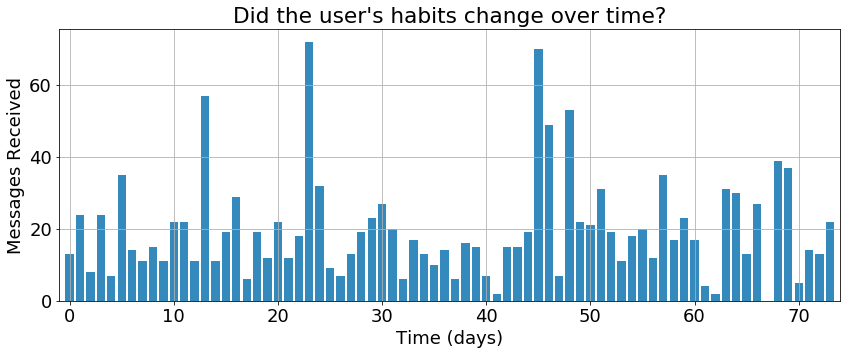

In [15]:
count_data = np.loadtxt("Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/Chapter1_Introduction/data/txtdata.csv")
n_count_data = len(count_data)
plt.figure(figsize=(14,5))
plt.bar(np.arange(n_count_data),count_data,color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Messages Received")
plt.title("Did the user's habits change over time?")
plt.xlim(-1,n_count_data)
plt.grid();

## Running the PYMC3 Model

For this problem, we assume the number of texts sent is a Poisson distribution. The Poisson distribution requires a single parameter $\lambda$ that identifies the mean value of the distribution. 

The value of $\lambda$ is unknown, but could be any decimal value. We start off assuming a *__prior distribution__* for the value of $\lambda$. What we use for this doesn't make too much difference, as long as it's reasonable. In the text, they use an exponential distribution. This distribution has a single parameter $\alpha$, with an expected value of $1/\alpha$. Matching that to our guess for $\lambda$, we create two distributions: $\lambda_1$ is the value before the "switch date" $\tau$, and $\lambda_2$ is the value after $\tau$. $\tau$ itself is a discrete value, and can be any date in the data set period. In this example, we just assume a uniform distribution (each date is equally likely) for $\tau$.

When we set up the model, we create the needed distributions for the priors of our parameters $\lambda_1$, $\lambda_2$, and $\tau$. Then we build the model we expect for our actual data: a Poisson distribution with two values of $\lambda$ corresponding to the split time periods. Getting the model function for the $\lambda$ step function is a little odd, and in pymc3 it is done in ```theano.tensor.switch()```. Follow the code below for the syntax of that function.

The final steps to run the simulation are to set up the Monte Carlo Sampler (using Metropolis here), and then run for an appropriate number of samples. It is best to burn off a number of samples to tune the posterior distribution, in case the prior is far enough off that it would skew the results. This run uses 5,000 samples to tune, then takes 10,000 additional samples for the result.

Optimization terminated successfully.
         Current function value: 495.906594

100%|██████████| 10000/10000 [00:03<00:00, 2804.05it/s]



         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12

tau:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  43.282           0.877            0.029            [42.000, 44.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  41.000         43.000         43.000         44.000         44.000


lambda_1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  17.763           0.645            0.017            [16.520, 19.057]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  16.528         17.334         17.732         18.188         19.074


lambda

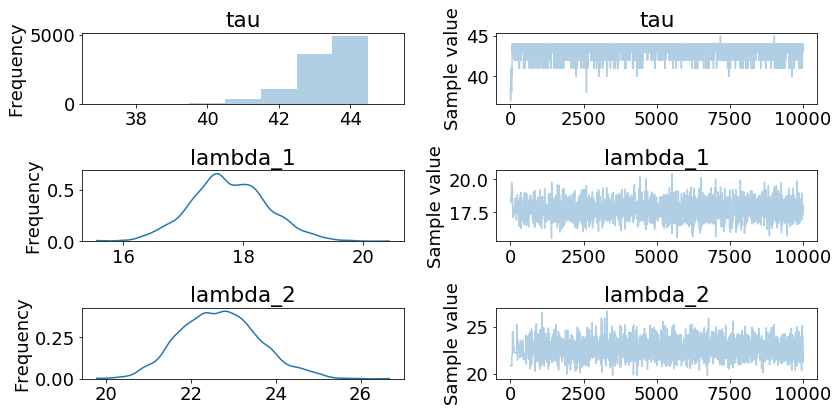

In [16]:
def switch(tau, l1, l2):
    out = np.zeros_like(n_count_data)
    out[:tau] = l1
    out[tau:] = l2
    return out

with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau  = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

    lambda_ = tt.switch(tau >= np.arange(n_count_data), lambda_1, lambda_2)
    #lambda_ = pm.Deterministic("lambda", switch(tau, lambda_1, lambda_2))
    observation = pm.Poisson("observation", lambda_, observed=count_data)

    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=7000, step=step, start=start)

pm.traceplot(trace);
pm.summary(trace)

The above traceplot summarizes the results by itself, but below is a set of plots to match the book's. 

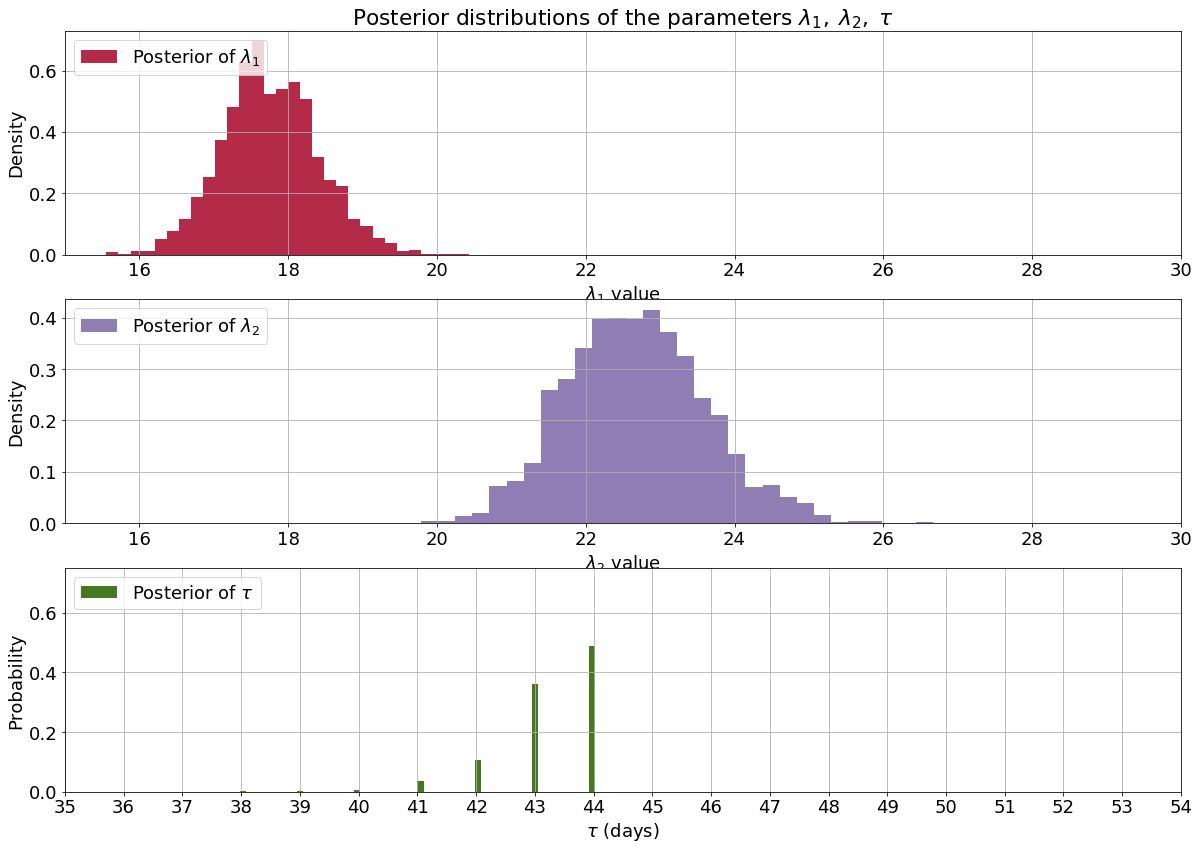

In [17]:
plt.figure(figsize=(20,14))
ax = plt.subplot(311)
plt.hist(trace['lambda_1'], histtype='stepfilled', bins=30, alpha=0.85,
         label="Posterior of $\lambda_1$", color="#A60628", normed=True) 
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameters \
$\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15,30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")
plt.grid()

ax = plt.subplot(312)
plt.hist(trace['lambda_2'], histtype='stepfilled', bins=30, alpha=0.85,
         label="Posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15,30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")
plt.grid()

ax = plt.subplot(313)
w = 1.0/trace['tau'].shape[0] * np.ones_like(trace['tau'])
plt.hist(trace['tau'], bins=n_count_data, alpha=1,
         label=r"Posterior of $\tau$", color="#467821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, 0.75])
plt.xlim([35, n_count_data-20])
plt.xlabel(r"$\tau$ (days)")
plt.ylabel("Probability")
plt.grid();

## Expected value of $\lambda$

The above plots indicate that there is very likely a change at day 44 of the period. We can visualize this change better by calculating the expected value of $\lambda$ for each day in the study based on our posterior distributions.

The expected value is obtained for a given day by averaging the 10,000 samples that were taken. For a given sample, the value of $\lambda$ is either $\lambda_1$ if $\tau$ is after the day, or $\lambda_2$ if $\tau$ is before the day. We create a mask marking indices as ```True``` if $\tau > \mathrm{day}$. Any samples where $\mathrm{mask}=\mathrm{True}$ would report $\lambda_1$ for that day. Any samples where $\mathrm{mask}=\mathrm{False}$ would report $\lambda_2$. Summing all of those values up and dividing by the number of samples gives us our expected value for that day.

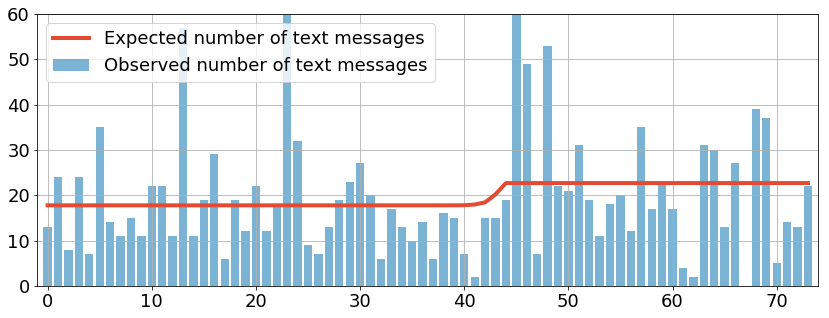

In [18]:
N = trace['tau'].shape[0]
expected = np.zeros(n_count_data)
for day in range(n_count_data):
    mask = trace['tau'] > day    # indices where the sample switch date is
                                 # after the given day
    expected[day] = (trace['lambda_1'][mask].sum() + 
                     trace['lambda_2'][~mask].sum())/N

plt.figure(figsize=(14,5))
plt.plot(range(n_count_data), expected, lw=4, color='#e24a33', 
         label="Expected number of text messages")
plt.bar(np.arange(n_count_data), count_data, color='#348abd', alpha=0.65,
        label="Observed number of text messages")
plt.xlim(-1,n_count_data)
plt.ylim(0,60)
plt.legend(loc='upper left')
plt.grid();

## Calculating Statistical Significance

The quickest question we can answer is what is the probability that $\lambda_1 < \lambda_2$. That can be estimated simply by the fraction of samples where this relationship holds.

In [19]:
numerator = (trace['lambda_1']<trace['lambda_2']).sum()
denominator = trace['lambda_1'].shape[0]
direct = (trace['lambda_1']<trace['lambda_2']).mean()

print("{0}/{1} samples hold".format(numerator, denominator))
print("{0:.2f}% probability lambda_1 < lambda_2".format(direct*100))

10000/10000 samples hold
100.00% probability lambda_1 < lambda_2


We can also look at the probability that the difference is large.

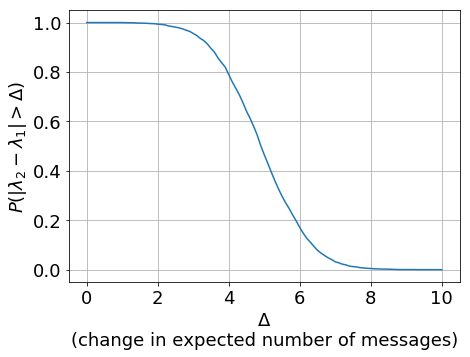

In [20]:
delta = np.arange(0,10.1,0.1)
P_delta = np.zeros_like(delta)
for i,d in enumerate(delta):
    P_delta[i] = (abs(trace['lambda_2']-trace['lambda_1']) >= d).mean()

plt.figure(figsize=(7,5))
plt.plot(delta,P_delta)
plt.xlabel("$\Delta$\n(change in expected number of messages)")
plt.ylabel("$P(|\lambda_2-\lambda_1| > \Delta)$")
plt.grid();

## Are there two switch points?

We can extend our model to see if there are two switch points easily enough. Unless there's a better way to do this, we can embed a second ```theano.tensor.switch()``` as the else condition for the first switch.

100%|██████████| 10000/10000 [00:05<00:00, 1727.23it/s]


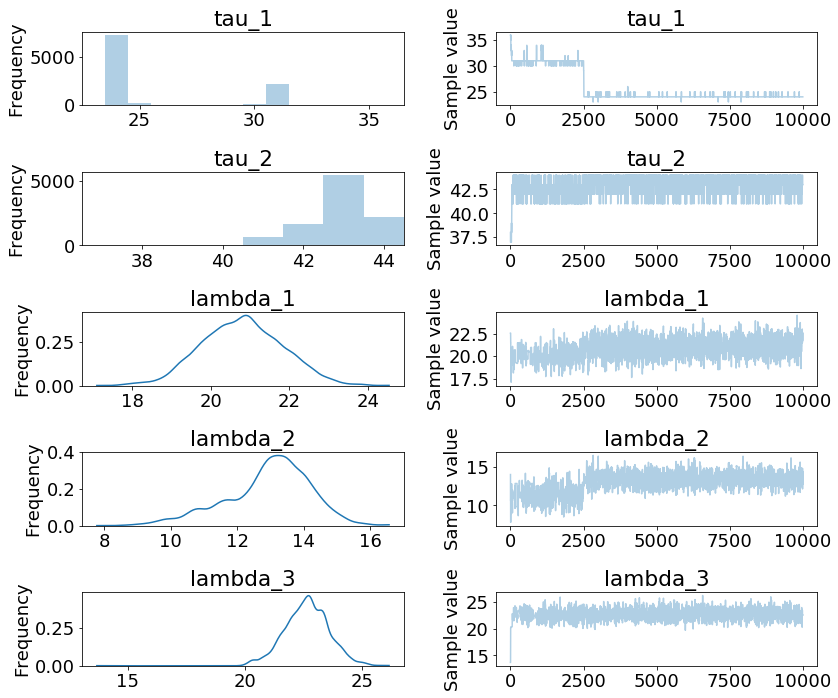

In [21]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)
    
    tau_1  = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data-1)
    tau_2  = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)

    lambda_a = tt.switch(tau_2 >= np.arange(n_count_data), lambda_2, lambda_3)
    lambda_  = tt.switch(tau_1 >= np.arange(n_count_data), lambda_1, lambda_a)
    observation = pm.Poisson("observation", lambda_, observed=count_data)

    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

pm.traceplot(trace);

There seems to be, according to this analysis! Which comes out differently than the original text based on pymc. Looking at the expected value of $\lambda$ by day, this result does seem to make sense, however.

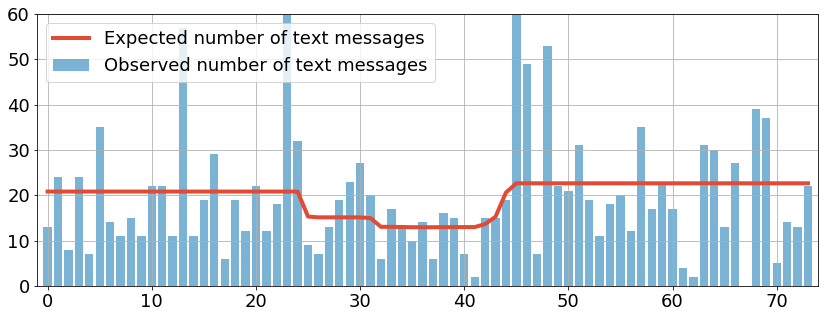

In [22]:
N = trace['tau_1'].shape[0]
expected = np.zeros(n_count_data)
for day in range(n_count_data):
    mask1 = trace['tau_1'] >= day    
    mask2 = (trace['tau_1'] < day) & (trace['tau_2'] >= day)
    mask3 = trace['tau_2'] < day
    
    expected[day] = (trace['lambda_1'][mask1].sum() + 
                     trace['lambda_2'][mask2].sum() +
                     trace['lambda_3'][mask3].sum() )/N

plt.figure(figsize=(14,5))
plt.plot(range(n_count_data), expected, lw=4, color='#e24a33', 
         label="Expected number of text messages")
plt.bar(np.arange(n_count_data), count_data, color='#348abd', alpha=0.65,
        label="Observed number of text messages")
plt.xlim(-1,n_count_data)
plt.ylim(0,60)
plt.legend(loc='upper left')
plt.grid();

# Exercises

## Problem 1
Using ```trace['lambda_1']``` and ```trace['lambda_2']``` of the first example, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [23]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau  = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

    lambda_ = tt.switch(tau >= np.arange(n_count_data), lambda_1, lambda_2)
    observation = pm.Poisson("observation", lambda_, observed=count_data)

    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

print("λ1: {0:.2f}".format(trace['lambda_1'].mean()))
print("λ2: {0:.2f}".format(trace['lambda_2'].mean()))

100%|██████████| 10000/10000 [00:03<00:00, 2977.29it/s]

λ1: 17.77
λ2: 22.65


## Problem 2
What is the expected percentage increase in text-message rates? *Hint: Compute the mean of $(\lambda_2 - \lambda_1)/\lambda_1$.*

In [24]:
diff = trace['lambda_2']-trace['lambda_1']
print("Expected increase: {0:.2f}%".format((diff/trace['lambda_1']).mean()*100))

Expected increase: 27.62%


## Problem 3
What is the mean of $\lambda_1$ given that we know $\tau$ is less than 45. That is, suppose we have been given new information that the change in behavior occurred prior to day 45. What is the expected value of $\lambda_1$ now? *Hint: you do not need to redo the PYMC3 part; just consider all instances where $\tau < 45$.*

In [25]:
mask = trace['tau'] < 45
print("Updated λ1: {0:.2f}".format(trace['lambda_1'][mask].mean()))

Updated λ1: 17.77


Well obviously, since $\tau=45$ from the analysis. Not a very satisfying answer. What if we know that $\tau<40$?

In [26]:
mask = trace['tau'] < 40
print("Updated λ1: {0:.2f}".format(trace['lambda_1'][mask].mean()))

Updated λ1: 19.26
